In [1]:
import pandas as pd
import numpy as np
from generate_data import generate_data
from discrete_lognormal import DiscreteLognormal
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,5)
from timeit import default_timer as timer

/usr/local/anaconda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/usr/local/anaconda/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [2]:
np.random.seed(2)
data = generate_data()
pois = sm.Poisson(data.y, data.x_df)
pois_fit = pois.fit(method="ncg")

Optimization terminated successfully.
         Current function value: 35.297809
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
         Hessian evaluations: 10


In [3]:
# Add names for alpha
names = list(data.x_df)
names_alpha = [s + "_alpha" for s in names]

# Create starting parameters
start_params = np.zeros(22)
start_params[:11] = pois_fit.params
start_params[11] = -1.

# Create DiscreteLognormal model and fit it with Newton's method
mod = DiscreteLognormal(data.y, data.x_df, extra_params_names=names_alpha)
mod_fit = mod.fit(method = "newton", start_params = start_params, maxiter=100, penalty=1e-4)

Optimization terminated successfully.
         Current function value: 5.905535
         Iterations 7


In [4]:
# Let's compare the generalized Poisson and the discrete Lognormal
gpois_mdl = sm.GeneralizedPoisson(data.y, data.x_df)
gpois_res = gpois_mdl.fit(method="ncg")
mean_gpois = gpois_res.predict()
var_gpois = ((1 + gpois_res.params[-1])**2) * mean_gpois

Optimization terminated successfully.
         Current function value: 5.992079
         Iterations: 8
         Function evaluations: 40
         Gradient evaluations: 38
         Hessian evaluations: 8


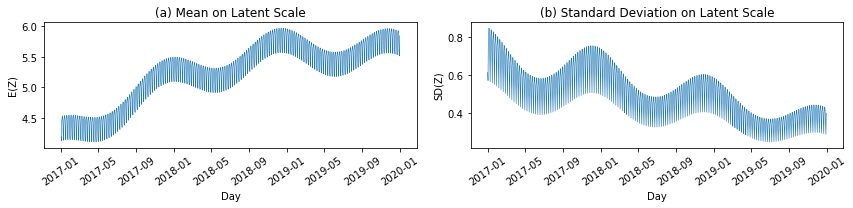

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))
rotate_degrees = 35

ax[0].plot(data.days, data.mu, linewidth=0.6)
ax[0].set_xlabel("Day")
ax[0].set_ylabel("E(Z)")
ax[0].set_title("(a) Mean on Latent Scale")
ax[0].tick_params(axis='x', labelrotation=rotate_degrees)

ax[1].plot(data.days, data.sigma, linewidth=0.6)
ax[1].set_xlabel("Day")
ax[1].set_ylabel("SD(Z)")
ax[1].set_title("(b) Standard Deviation on Latent Scale")
ax[1].tick_params(axis='x', labelrotation=rotate_degrees)

plt.tight_layout()
fig.savefig("./plots/mean_var.png")
plt.show()

[]

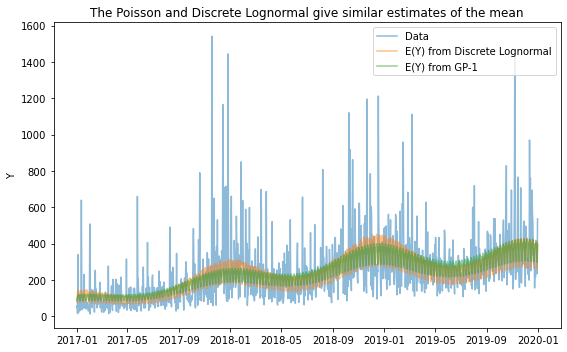

In [6]:
blending = 0.5
plt.plot(data.days, data.y, alpha=blending, label="Data")
plt.plot(data.days, mod_fit.predict(), alpha=blending, label="E(Y) from Discrete Lognormal")
plt.plot(data.days, mean_gpois, alpha=blending, label="E(Y) from GP-1")
plt.legend()
plt.ylabel("Y")
plt.title("The Poisson and Discrete Lognormal give similar estimates of the mean")
plt.tight_layout()
plt.savefig("./plots/mean_functions.png")
plt.plot()

[]

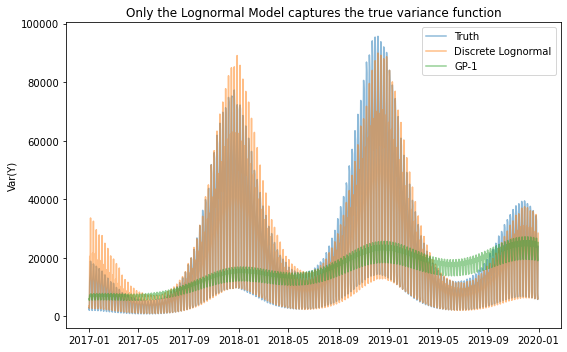

In [7]:
true_params = np.concatenate([data.beta, data.alpha], axis=0)
# NOTE: Setting n really high makes the plot less wiggly
plt.plot(data.days, mod.predict(params=true_params, n=100000, return_variance=True), alpha=blending, label="Truth")
plt.plot(data.days, mod_fit.predict(n=100000, return_variance=True), alpha=blending, label="Discrete Lognormal")
plt.plot(data.days, var_gpois, alpha=blending, label="GP-1")
plt.legend()
plt.ylabel("Var(Y)")
plt.title("Only the Lognormal Model captures the true variance function")
plt.tight_layout()
plt.savefig("./plots/variance_functions.png")
plt.plot()